In [213]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.datasets import make_spd_matrix
import sys
import operator
from scipy.stats import multivariate_normal

In [214]:
np.random.seed(43)

In [215]:
def generate_data(n_feat,n_clust,mu_list,cov_list,n_sample_per_clust):
    
    features=[]
    for x in range(n_feat):
        features.append([])
        
    for mu, cov in zip(mu_list,cov_list):
        TT=np.random.multivariate_normal(mu,cov,n_sample_per_clust).T
        for i in range(n_feat):
            features[i].append(TT[i])
    for i in range(len(features)):
        features[i]=np.concatenate(features[i])   
    labels=[]
    for i in range(1,n_clust+1):
        labels+=[i]*n_sample_per_clust
    
    data = {'label':labels}
    
    for i in range(len(features)):
        data['feat_'+str(i)]=features[i]
    
    df=pd.DataFrame(data=data)
    return df

In [216]:
def plot_data_scatter(feat1,feat2,sz,label,data):
    plt.scatter(x=data[feat1],y=data[feat2],s=sz,c=data[label])

In [217]:
class Cluster:
    def __init__(self,mu,cov):
        assert(len(mu)*len(mu)==len(cov)*len(cov[0]))
        self.mu=mu
        self.cov=cov

In [218]:
def calculate_prob(x,mu,cov,w):
    prob=w
    prob*=multivariate_normal.pdf(x=x,cov=cov,mean=mu)
    return prob


In [219]:
def normalize(probs):
    #print("sum ",sum(probs))
    return [p/sum(probs) for p in probs]

In [220]:
def getMatrix(size):
    from scipy import random
    A= random.rand(size,size)
    B=np.dot(A,A.transpose())
    return B

In [221]:
def initparams(n_clust,n_feat):
    params={}
    for i in range(n_clust):
        params['mu'+str(i+1)]=list(np.random.uniform(size=n_feat,low=0.001,high=1.0))
        params['cov'+str(i+1)]=list(getMatrix(n_feat))
    
    ws=[]
    for i in range(n_clust):
        ws.append(1/n_clust)
    params['weights']=ws
    return params

In [222]:
#todo incorporate overall loglikelihood here
def calculate_change(old,new):
    mus=[t for t in list(old.columns) if "mu" in t]
    covs=[t for t in list(old.columns) if "cov" in t]
    
    d=0.0
    
    for mu in mus:
        for i in range(len(old)):
            d+=(old[mu][i]- new[mu][i])**2
    
    return d**0.5

In [223]:
def expectation(df,params,n_clust):
    print("EXPECTATION")
    cur=0
    for row in df.itertuples(index=False, name='Pandas'):
        x=list(np.asarray(row))
        
        for i in range(n_clust+1):
            del x[-1]
        
        clust_probs=[]
        for i in range(n_clust):
            pp=calculate_prob(x,list(params["mu"+str(i+1)]),list(params["cov"+str(i+1)]),params['weights'][i])
            df["w"+str(i+1)][cur]=pp
            clust_probs.append(pp)
        clust_probs=normalize(clust_probs)
        index, value = max(enumerate(clust_probs), key=operator.itemgetter(1))
        df['label'][cur]=index+1
        cur+=1
    
    return df

In [224]:
def maximize(df,params,n_clust,feat_list):
    #print(params)
    print("MAXIMIZE")
    total=len(df)
    
    feats=np.asmatrix(df[feat_list])
    feats=feats.tolist()
    feats=np.array(feats)
    #print(type(feats[0][0]))
    for i in range(n_clust):
        cur_mu=np.array(params["mu"+str(i+1)])
        #update mu 
        dd="w"+str(i+1)
        #print(df[dd][0])
        new_mu=np.zeros(len(feat_list))
        #print(type(new_mu[0]))
        for j in range(df.shape[0]):
            #print(feats[j])
            new_mu+=(feats[j])*df[dd][j]
        new_mu/=(df[dd].sum())
        params["mu"+str(i+1)]=new_mu
        #update cov
        new_cov=np.zeros((len(feat_list),len(feat_list)))
        #print("new cov")
        #print(new_cov)
        for j in range(df.shape[0]):
            new_cov+=feats[j].T * feats[j] * df[dd][j]
        
        new_cov/=(df[dd].sum())
        #print(new_cov)
        params["cov"+str(i+1)]=list(new_cov)
        #print(new_cov)
        
        #update w
        params['weights'][i]=(df[dd].sum())/1.0*total
        
        
    #print(params)
    return params

In [225]:
def loglikelihood(df,n_clust,params,feat_list):
    total=len(df)
    feats=np.asmatrix(df[feat_list])
    feats=feats.tolist()
    feats=np.array(feats)
    
    total_log_like=0
    
    for i in range(df.shape[0]):
        tmp_sum=0
        for j in range(n_clust):
            tmp_sum+=calculate_prob(cov=list(params["cov"+str(j+1)]),mu=list(params["mu"+str(j+1)]),w=params["weights"][j],x=feats[i])
        total_log_like+=np.log(tmp_sum)
    
    return total_log_like
    

In [226]:
def EM(df,n_clust,n_feat):
    
    params=initparams(n_clust,n_feat)
    #print(params)
    params=pd.DataFrame(params)
    
    #print(params)
    
    
    df_=df.copy(deep=True)
    
    #random labeling
    df_['label']=np.random.randint(1, n_clust+1, df.shape[0])
    
    for  i in range(1,n_clust+1):
        df_['w'+str(i)]=(1/n_clust)
    
    #print(df_)
    
    dist=sys.maxsize
    eps=10
    n_iter=0
    #print(calculate_change(params,params))
    feat_list=list(df.columns)
    feat_list.remove('label')
    #print(loglikelihood(df=df_,feat_list=feat_list,n_clust=n_clust,params=params))
    
    log_old = loglikelihood(df=df_,feat_list=feat_list,n_clust=n_clust,params=params)
    
    while( dist > eps):
        n_iter+=1
        
        new_lab=expectation(df_.copy(),params,n_clust)
        
        
        #print(new_lab)
        
        new_params=maximize(new_lab,params.copy(),n_clust,feat_list)
        
        
        
        df_=new_lab
        params=new_params
        log_new=loglikelihood(df=df_,feat_list=feat_list,n_clust=n_clust,params=params)
        
        if(abs(abs(log_old)-abs(log_new))<=eps):
            break
    return params

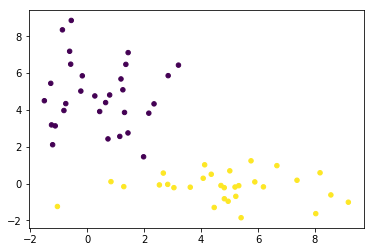

EXPECTATION


/home/numan947/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/home/numan947/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


MAXIMIZE


/home/numan947/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


ValueError: the input matrix must be positive semidefinite

In [227]:
mu1 = [0, 5]
sig1 = [ [2, 0], [0, 3] ]

mu2 = [5, 0]
sig2 = [ [4, 0], [0, 1] ]


df=generate_data(2,2,[mu1,mu2],[sig1,sig2],30)
df.head()

df_t=df.drop(columns=["label"])
plot_data_scatter("feat_0","feat_1",20,"label",df)
plt.show()



EM(df,2,2)